In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.mstats import winsorize
from scipy.stats import loguniform, uniform, randint


from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import StackingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

from xgboost import XGBClassifier

Некоторые функции:

In [11]:
def draw_roc_curve(fpr, tpr, auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC-кривая')
    plt.legend()
    plt.savefig('roc_curve.png', dpi=600)
    plt.show()
    
def draw_histograms(data, rows, cols):
    plt.figure(figsize=(20, 10))
    for i, value in enumerate(data.columns):
        plt.subplot(rows,cols,i+1)
        sns.histplot(data_train[value].dropna(), bins=50, color='green', kde=True)
        plt.title(value)
    plt.tight_layout()
    plt.show()


In [4]:
data_train = pd.read_csv('cs-training.csv')
data_test = pd.read_csv('cs-test.csv')

In [ ]:
print(data_train.head())
print(data_test.head())
data_train.columns

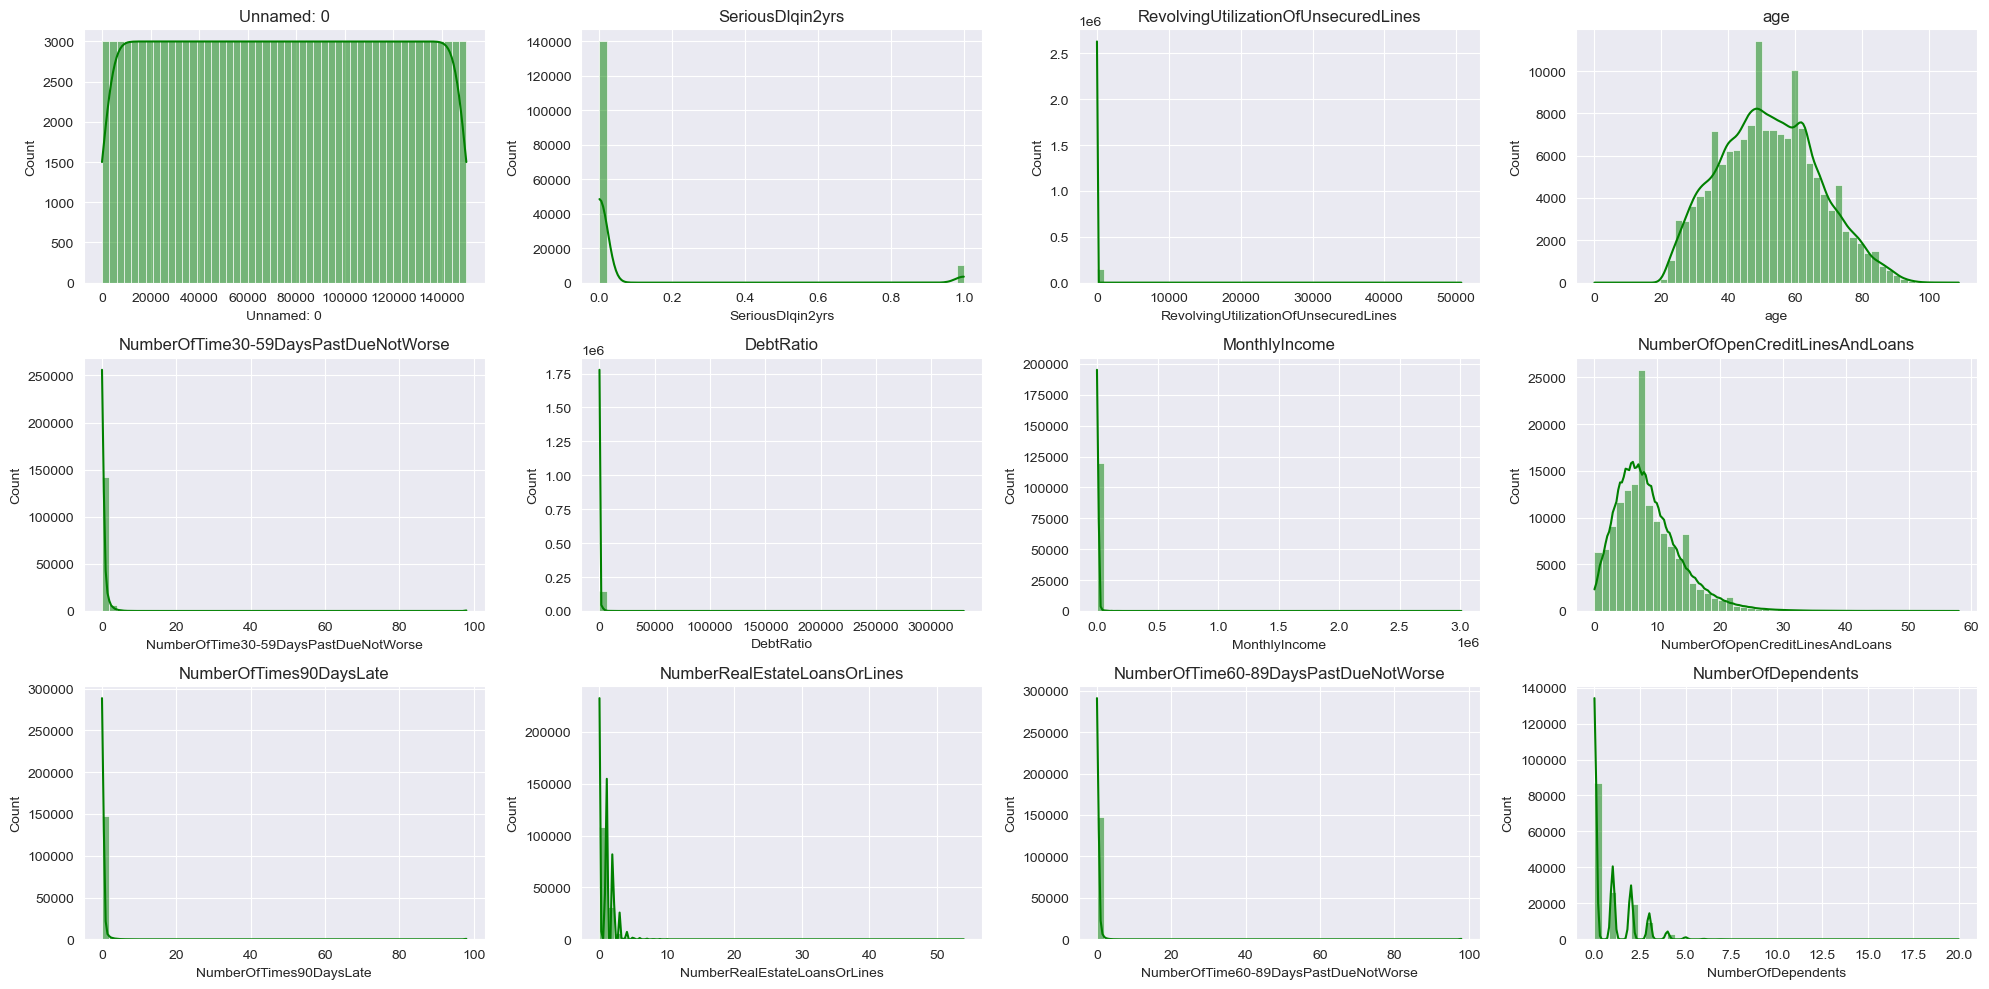

In [31]:
draw_histograms(data_train, 3, 4)

Из графиков выше видим наличие выбросов

In [5]:
def replace_96_98(series):
    # Заменяем 96 и 98 на медиану (исключая эти значения из расчета)
    valid_values = series[~series.isin([96, 98])]
    median = valid_values.median()
    return series.replace([96, 98], median)

# Применяем ко всем столбцам с просрочками
late_columns = [
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse', 
    'NumberOfTimes90DaysLate'
]

for col in late_columns:
    data_train[col] = replace_96_98(data_train[col])
    data_test[col] = replace_96_98(data_test[col])  # Используем ту же медиану, что и для train!
    

Восполним пропуски в данных:

In [ ]:
print("Количество пропусков в каждом столбце:")
print(data_train.isnull().sum())

sns.heatmap(data_train.isnull(), cbar=False, cmap='viridis')
plt.title("Карта пропусков в данных")
plt.show()

Number of dependents in family excluding themselves (spouse, children etc.) - integer --> заполнение модой

Monthly income - real --> заполнение средним

Сверху визуализация заполненных (незаполненных) пропусков.

В библиотеке sklearn для предобработки данных есть подходящие методы, воспользуемся ими.

In [6]:
data_train.loc[data_train['age'] == 0, 'age'] = data_train['age'].median()
data_train['MonthlyIncome'] = data_train['MonthlyIncome'].replace(np.nan,data_train['MonthlyIncome'].median())
data_train['NumberOfDependents'].fillna(data_train['NumberOfDependents'].median(), inplace=True)

data_test.loc[data_test['age'] == 0, 'age'] = data_test['age'].median()
data_test['MonthlyIncome'] = data_test['MonthlyIncome'].replace(np.nan,data_test['MonthlyIncome'].mean())
data_test['NumberOfDependents'].fillna(data_test['NumberOfDependents'].median(), inplace=True)

C:\Users\Анна\AppData\Local\Temp\ipykernel_9344\1427489128.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train['NumberOfDependents'].fillna(data_train['NumberOfDependents'].median(), inplace=True)
C:\Users\Анна\AppData\Local\Temp\ipykernel_9344\1427489128.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

In [7]:
X = data_train.drop(['SeriousDlqin2yrs'],axis=1)
y = data_train['SeriousDlqin2yrs']

W = data_test.drop(['SeriousDlqin2yrs'],axis=1)
z = data_test['SeriousDlqin2yrs']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=123, test_size = 0.25)

scaler = StandardScaler().fit(X_train)
X_train_processed = scaler.transform(X_train)
X_test_processed = scaler.transform(X_test)

## Попробуем разные модели:

### <span style="color:#CFFFDC">Логистическая регрессия</span>

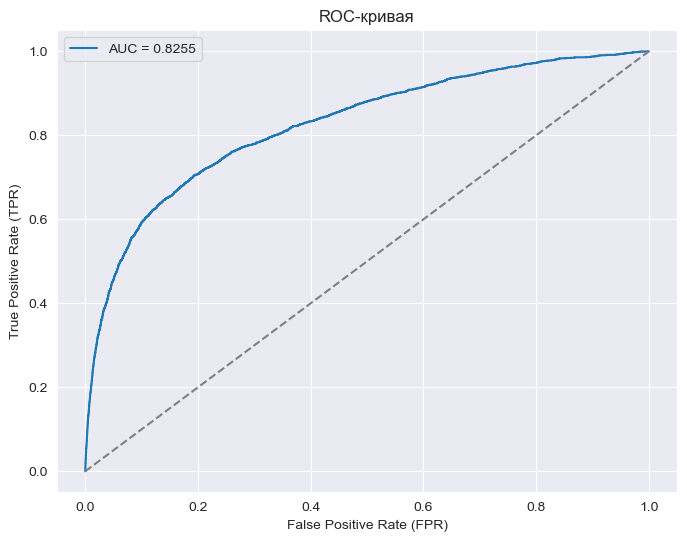

AUC-ROC: 0.8255


In [44]:
model = LogisticRegression(penalty='l1', max_iter=500, solver='liblinear', C=0.01, class_weight='balanced', random_state=123)
model.fit(X_train_processed, y_train)

y_pred = model.predict_proba(X_test_processed)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_pred)

auc = roc_auc_score(y_test, y_pred)
draw_roc_curve(fpr, tpr, auc)

print(f"AUC-ROC: {auc:.4f}")

Попробуем кросс-валидацию для модели логистической регрессии, что бы подобрать лучшие гиперпараметры

In [43]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga']    
}

model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='roc_auc')
grid_search.fit(X_train_processed, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая оценка:", grid_search.best_score_)

Лучшие параметры: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Лучшая оценка: 0.8071742301630822


In [ ]:
param_dist = {
    'C': loguniform(1e-3, 1e3), 
    'penalty': ['l1', 'l2'],   
    'class_weight': [None, 'balanced', {0:1, 1:5}], 
    'solver': ['liblinear', 'saga'] 
}

model = LogisticRegression(max_iter=1000)

# Стратифицированная кросс-валидация на 5 фолдов
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,  # количество случайных комбинаций
    cv=cv,
    scoring='roc_auc',  
    n_jobs=-1,  # использовать все ядра CPU
    random_state=42,
    verbose=1
)

random_search.fit(X_train_processed, y_train)

print("Лучшие параметры:", random_search.best_params_)
print("Лучшая оценка:", random_search.best_score_)

### <span style="color:#AFCDBA">Случайный лес</span>

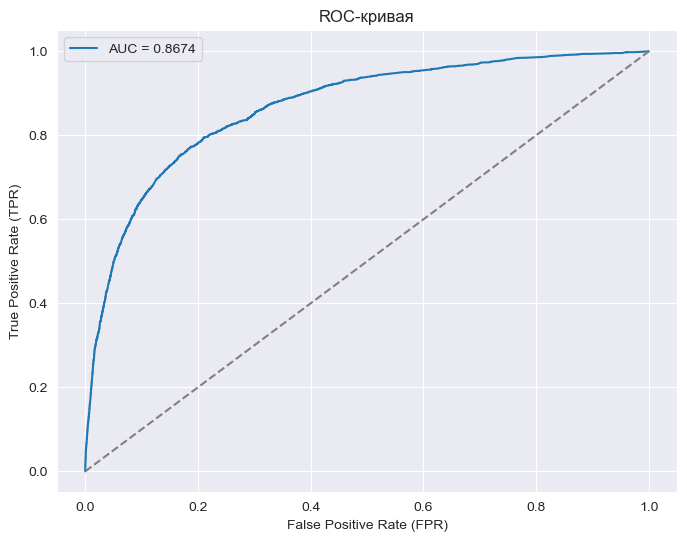

AUC-ROC: 0.8674


In [12]:
model = RandomForestClassifier(n_estimators=20, max_depth=5, min_samples_split=2)
model.fit(X_train_processed, y_train)

y_pred = model.predict_proba(X_test_processed)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_pred)

auc = roc_auc_score(y_test, y_pred)
draw_roc_curve(fpr, tpr, auc)

print(f"AUC-ROC: {auc:.4f}")

Попробуем кросс-валидацию для модели случайного леса, что бы подобрать лучшие гиперпараметры

In [48]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

model = RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid, cv=5)  # cv=5 — кросс-валидация на 5 фолдах
grid_search.fit(X_train_processed, y_train)

print("Лучшие параметры:", grid_search.best_params_)

KeyboardInterrupt: 

### <span style="color:#AFCDBA">XGBoost</span>

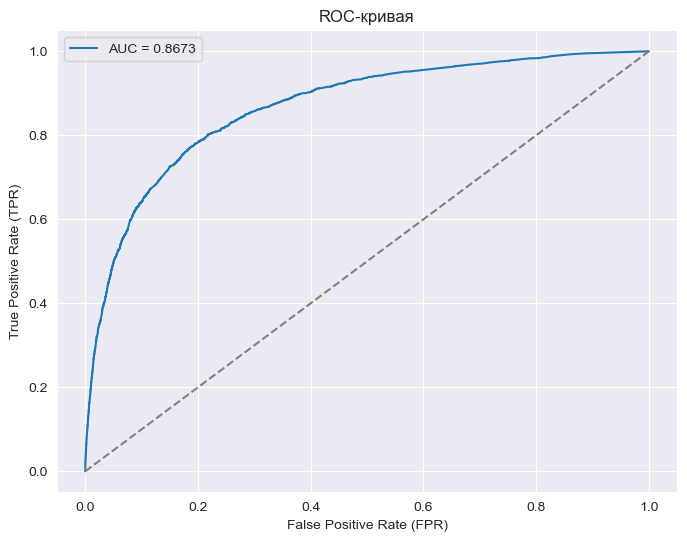

AUC-ROC: 0.8673


In [47]:
model = XGBClassifier(
    scale_pos_weight=1,  # Баланс классов
    eval_metric="auc",
    n_estimators=165,
    max_depth=3,
    learning_rate=0.016034047398805644,
    subsample=0.7675681414781061,
    colsample_bytree=0.8123538802630876,
    reg_alpha=0.9295515807202052,
    reg_lambda=0.17556041585306104,
)
model.fit(X_train_processed, y_train)

y_pred = model.predict_proba(X_test_processed)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_pred)

auc = roc_auc_score(y_test, y_pred)
draw_roc_curve(fpr, tpr, auc)

print(f"AUC-ROC: {auc:.4f}")

In [ ]:
param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.3),  # от 0.01 до 0.31
    "subsample": uniform(0.7, 0.3),       # от 0.7 до 1.0
    "colsample_bytree": uniform(0.7, 0.3),
    "reg_alpha": uniform(0, 1),           # от 0 до 1
    "reg_lambda": uniform(0, 1),
    "scale_pos_weight": [1, 5, 10]        # для дисбаланса
}

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42
)

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,           # Количество комбинаций
    scoring="roc_auc",   # Метрика (AUC)
    cv=5,                # Кросс-валидация
    n_jobs=-1,           # Использовать все ядра
    verbose=1
)

search.fit(X_train_processed, y_train)

print("Лучшие параметры:", search.best_params_)
print("Лучший AUC:", search.best_score_)